__Оглавление__
1. [First 16 male and female images lookup](##First)
2. [Препроцессинг - PCA и модельные данные на 2000 grayscale изображений](##Препроцессинг)
3. [Классификация: State of the art models](##Классификация)

__Источники__
- [Статья обзор Deep Learning in CV на хабре](https://habr.com/ru/company/mipt/blog/450732/)
- [Хороший kaggle ноутбук с немного похожей задачей](https://www.kaggle.com/serkanpeldek/face-recognition-on-olivetti-dataset/data?select=olivetti_faces_target.npy)
- [Документация торча](https://pytorch.org/docs/stable/torch.html)

In [4]:
# Gentleman pack
import numpy as np 
import pandas as pd 

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from mlxtend.classifier import StackingCVClassifier

# Dataset utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt

# Custom libs
from utils import DATA_DIR, random_images_of_gender, show_imgs, clf_proba_pipeline, threshhold_clf_controller, GS_pipeline
import rendering

<font color='#6D8CAA' size=8><center>Face Gender Classification problem </center></font>
***
<font size=5><center>__Задача распознавание лиц решается 3 подходами:__</font></center>

<center>1. Аналитически: использование лицевых черт;</center>
<center>2. Внешний вид: глобальные признаки;</center>
<center>3. Гибридный метод.</center>

> Здесь я попытался __сначала выделить черты лица__, взял 30 главных компонент среди 2000 (далее в PCA). 

> Затем все же __перешел к оптимизационному подходу__ c использованием имеющихся данных.

> Также провел __предобработку изображений c помощью pytorch transforms__. Так решается проблема освещенности, цвета, перспективы и т. п.

> В конце концов использовал надежный __нейросетевой подход__.   


__В датасете представлено 2 класса размеченных изображений по 50000 - мужских и женских лиц. Все фото обрезаны - необходимости распознавать лица нет.__

Проведенная работа включает:
- EDA (якобы) 
    - Краткий анализ датасета
    - Снижение размерности
- Machine Learning
    - Классификация методами обучения ML
    - Стэкинг ML моделей 
- Deep Learning
    - Предобработка - линейные преобразования и сэмплирование
    - Классификация нейронной сектой


In [5]:
print(f'Data dir content: {list(DATA_DIR.iterdir())}')

Data dir content: [PosixPath('images/female'), PosixPath('images/male')]


## First 16 male and female images lookup

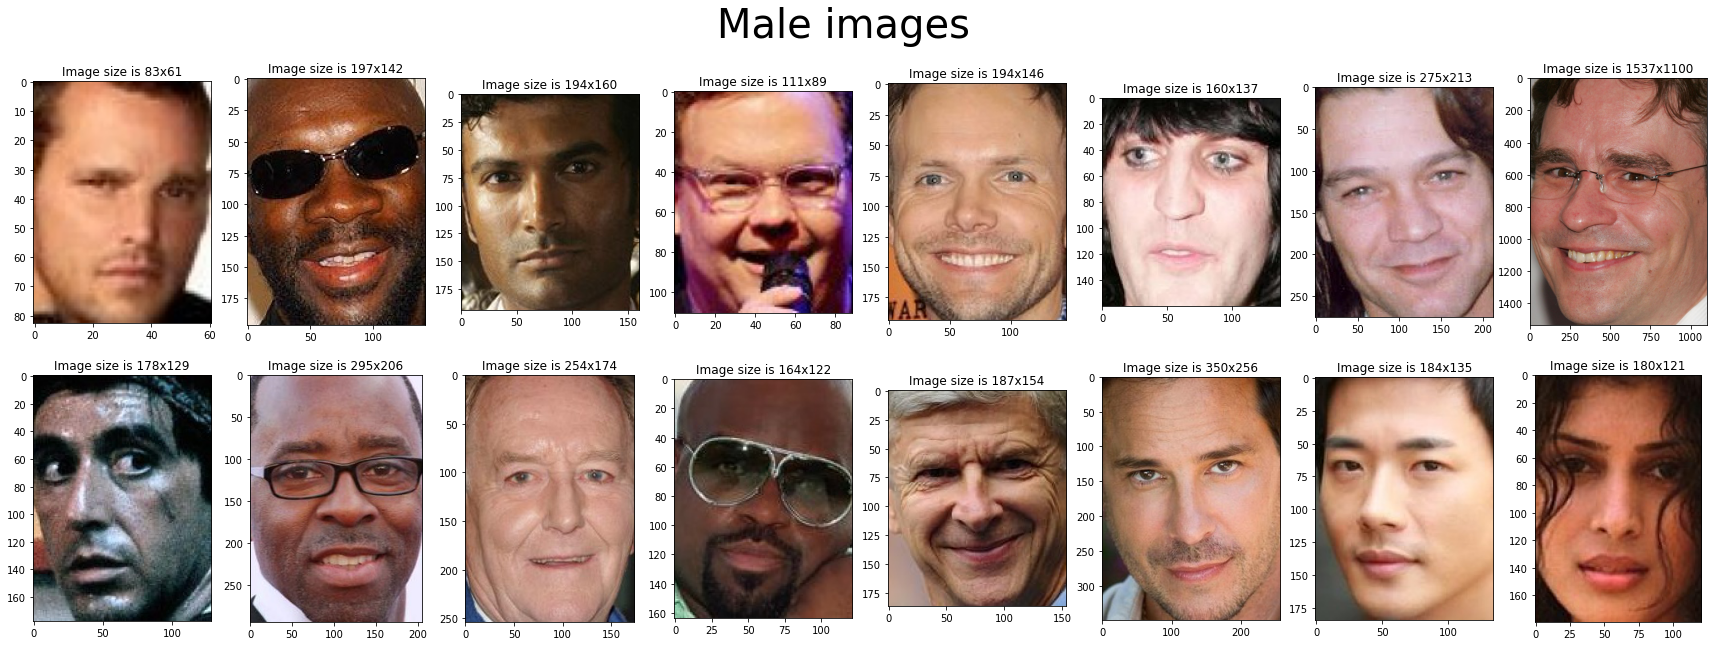

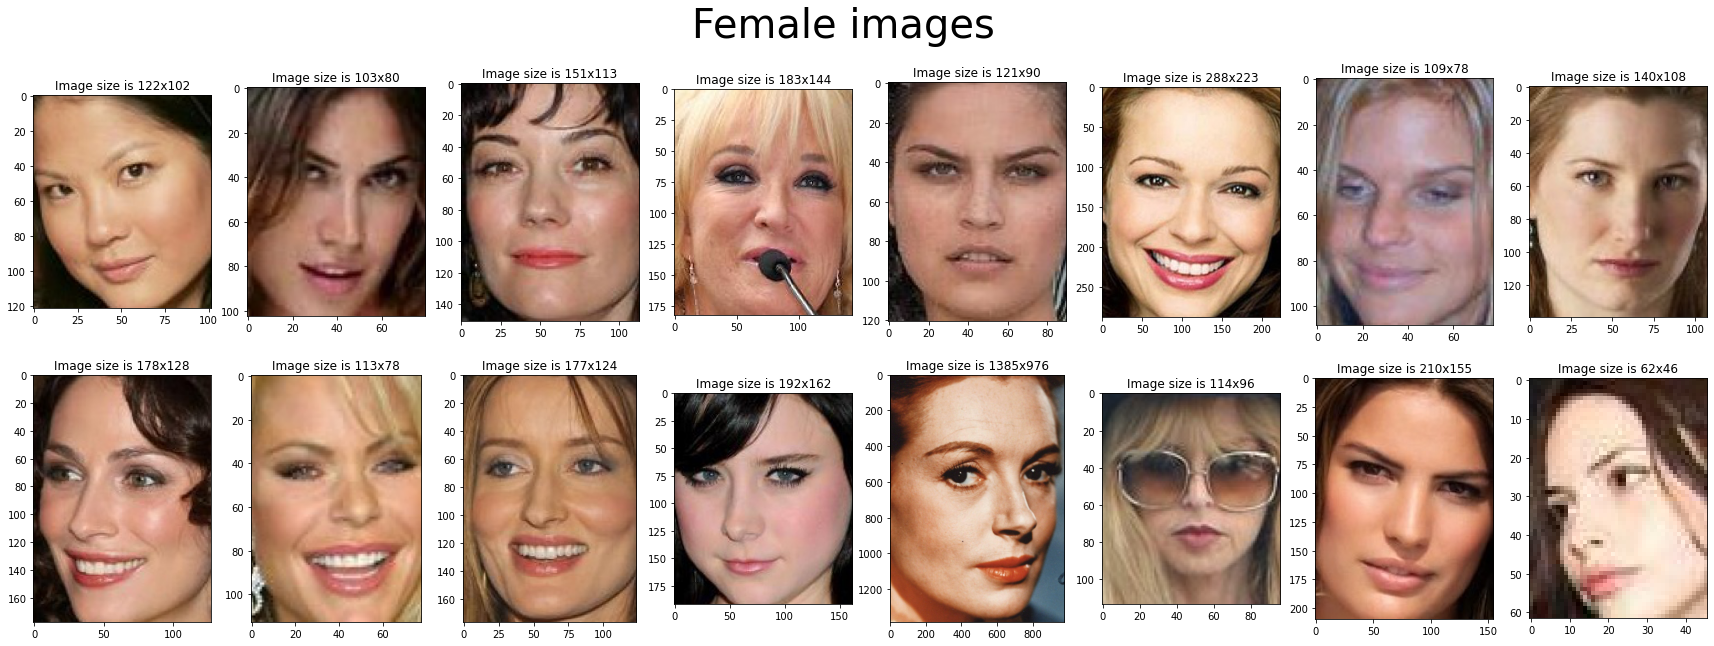

In [6]:
male_images = random_images_of_gender(16, 'male')
female_images = random_images_of_gender(16, 'female')

show_imgs(male_images, 'Male images');
show_imgs(female_images, 'Female images');

__Различаются:__
- размер изображения, качество
- перспектива, освещенность
- раса, национальность
- поза, наличие посторонних предметов
- украшения, очки, бороды, прочая стилистика


__Необходимо сделать ресайз__

__Препдполжительные рекомендации предобработки - для этапа дообучения лучшей модели:__

- аффинные преобразования
- яркость, контраст
- насыщенность, цвет
- обрезка - скорее будет хуже

_Иногда в датасете попадаются ошибки: женщины среди мужских фотографий, и наоборот_

Поскольку выражения и детали лиц отличаются, я бы не стал использовать батч меньше 32 элементов.

Для передачи данных в ML модель необходимо перевести изображения в тензорное представление.   


__Попробуем два варианта решения задачи__

1. В качестве бейзлайна посмотрим на PCA и алгоритмы из коробки __sklearn__;

3. Предполагаю, что __нейросети типа FaceNet__ дадут лучшее качество. Для рандомного сэмплирования и работы с матрицами я использую __pytorch.datasets__.

## Препроцессинг - PCA и модельные данные на 2000 grayscale изображений

<a class="anchor" id="2.2.">

### Информация о данных

In [14]:
transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        ])

data = datasets.ImageFolder(DATA_DIR, transform=transform)

print(f'{data}\nImages extensions: {data.extensions}')

batch_size = 2000
loader = DataLoader(data, batch_size=batch_size, shuffle=True)
datagen = iter(loader)
# images, labels = datagen.next()

X, target = tuple(map(lambda x: x.numpy(), datagen.next()))

Dataset ImageFolder
    Number of datapoints: 100009
    Root location: images
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=1)
               ToTensor()
           )
Images extensions: ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')


In [15]:
print(f"Всего {X.shape[0]} изображений в датасете")
print(f"Только {len(np.unique(target))} класса изображений - гендерная классификация")
print(f"Изображения приведены к размеру {X.shape[2]}x{X.shape[3]}")
print(f"Представление батчем тензоров вида {X.shape} со значениями интенсивности в \
{np.min(X.reshape(-1))} - {np.max(X.reshape(-1))} интервале и 3 канала цвета")

Всего 2000 изображений в датасете
Только 2 класса изображений - гендерная классификация
Изображения приведены к размеру 128x128
Представление батчем тензоров вида (2000, 1, 128, 128) со значениями интенсивности в 0.0 - 1.0 интервале и 3 канала цвета


In [16]:
X = X[:,0].reshape((X.shape[0], X.shape[2] * X.shape[3]))  # data reshape for PCA, removing RGB axis
print("X shape:", X.shape)

X shape: (2000, 16384)


__Разбиваем датасет на трэйн - тест__
 
80 % будет использовано для обучения и 20 % для валидации.

Изначальная рандомная выборка 2000 изображений обеспечивает сбалансированность классов М / Ж. Нечто вроде бутстреп подвыборки. 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=12)
print("X_train shape:",X_train.shape)
print("y_train shape:{}".format(y_train.shape))

X_train shape: (1600, 16384)
y_train shape:(1600,)


In [18]:
print(f'split is still balanced: coef={sum(y_train) / y_train.shape}')

split is still balanced: coef=[0.5075]


In [19]:
df = pd.DataFrame()
df['Gender'] = np.where(y_train, 'Male', 'Female')
males, females = df[df.Gender == 'Male'], df[df.Gender == 'Female']
    
rendering.hist_plotly(x=[males, females],\
            title_='Histogram of classes', x_label='Gender', y_label='Count', x_name=['Male', 'Female'])

__Попробуем классические методы unsupervised learning__

### Principle Component Analysis

Может быть, получиться произвести хорошее разделение классов.

__Кластеризация в двух главных компонентах__

In [20]:
mf_indicator = np.concatenate([y_train, y_test])  # male / female [0, 1] indicator; will be used to get classes later through tricky zero multiplication
fm_indicator = np.where(mf_indicator, 0, 1)  # inverted indicator
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

In [21]:
x_male, x_female = np.multiply(mf_indicator, X_pca.T).T[:, 0], np.multiply(fm_indicator, X_pca.T).T[:, 0]  # that is my tricky multiplication with X_pca
y_male, y_female = np.multiply(mf_indicator, X_pca.T).T[:, 1], np.multiply(fm_indicator, X_pca.T).T[:, 1] # the same with 2nd component
    
rendering.scatter_plotly(x=[x_male, x_female], y=[y_male, y_female], mode='markers', name=['Male', 'Female'],\
               title_='PCA images projections of gender', x_label='First component', y_label='Second component') 

Из распределения по опорным компонентам не видно, есть ли различие между классами. К сожалению.

Больше размазанность по первой размерности. Наверное, в края попадают самые мужественные мужчины и самые женственные женщины (Шутка)

__В целом, облако точек включает оба класса.__

Попробовал сравнить первую и третью, десятую, картина такая же. Похоже, алгоритм ничего не даст.


### Выбор оптимального числа компонент алгоритма

In [22]:
pca = PCA(n_components=X.shape[0])
pca.fit(X)
X_pca = pca.transform(X)

In [23]:
number_of_components = np.arange(pca.explained_variance_.shape[0])
log_variance = np.log(pca.explained_variance_)

rendering.scatter_plotly(x=[number_of_components], y=[log_variance], mode='lines', name=['Variance'], marker_color='orangered',\
                        title_='Logarithmic PCA algorithm Variance of Number of components', x_label='Components', y_label='Explained Variance')

Из графика выше видно, что в данной ситуации первые несколько компонент __не имеют__ большую объяснительную силу.

Тем не менее, попробуем сократить размерность, например, до 30 компонент.

In [24]:
number_of_components = number_of_components[:30]
log_variance = log_variance[:30]

rendering.scatter_plotly(x=[number_of_components], y=[log_variance], mode='lines', name=['Variance'], marker_color='orangered',\
                        title_='Logarithmic PCA algorithm Variance of Number of components', x_label='Components', y_label='Explained Variance')

### Изображения на 30 компонентах PCA

In [25]:
male_faces, female_faces = np.multiply(mf_indicator, X.T).T, np.multiply(fm_indicator, X.T).T
male_faces, female_faces = male_faces[male_faces.any(axis=1) > 0], female_faces[female_faces.any(axis=1) > 0]

print(f'number of male images - {male_faces.shape[0]}, number of female image - {female_faces.shape[0]}')

number of male images - 1007, number of female image - 993


In [26]:
n_components = 30
pca_male = PCA(n_components=n_components, whiten=True)  # whiten to decrease correlations, as there are quite many of components
pca_female = PCA(n_components=n_components, whiten=True)
pca_male.fit(male_faces);
pca_female.fit(female_faces);

### Есть ли видимая глазом разница в усредненных "лицах"

__PCA mean value Average Face__   

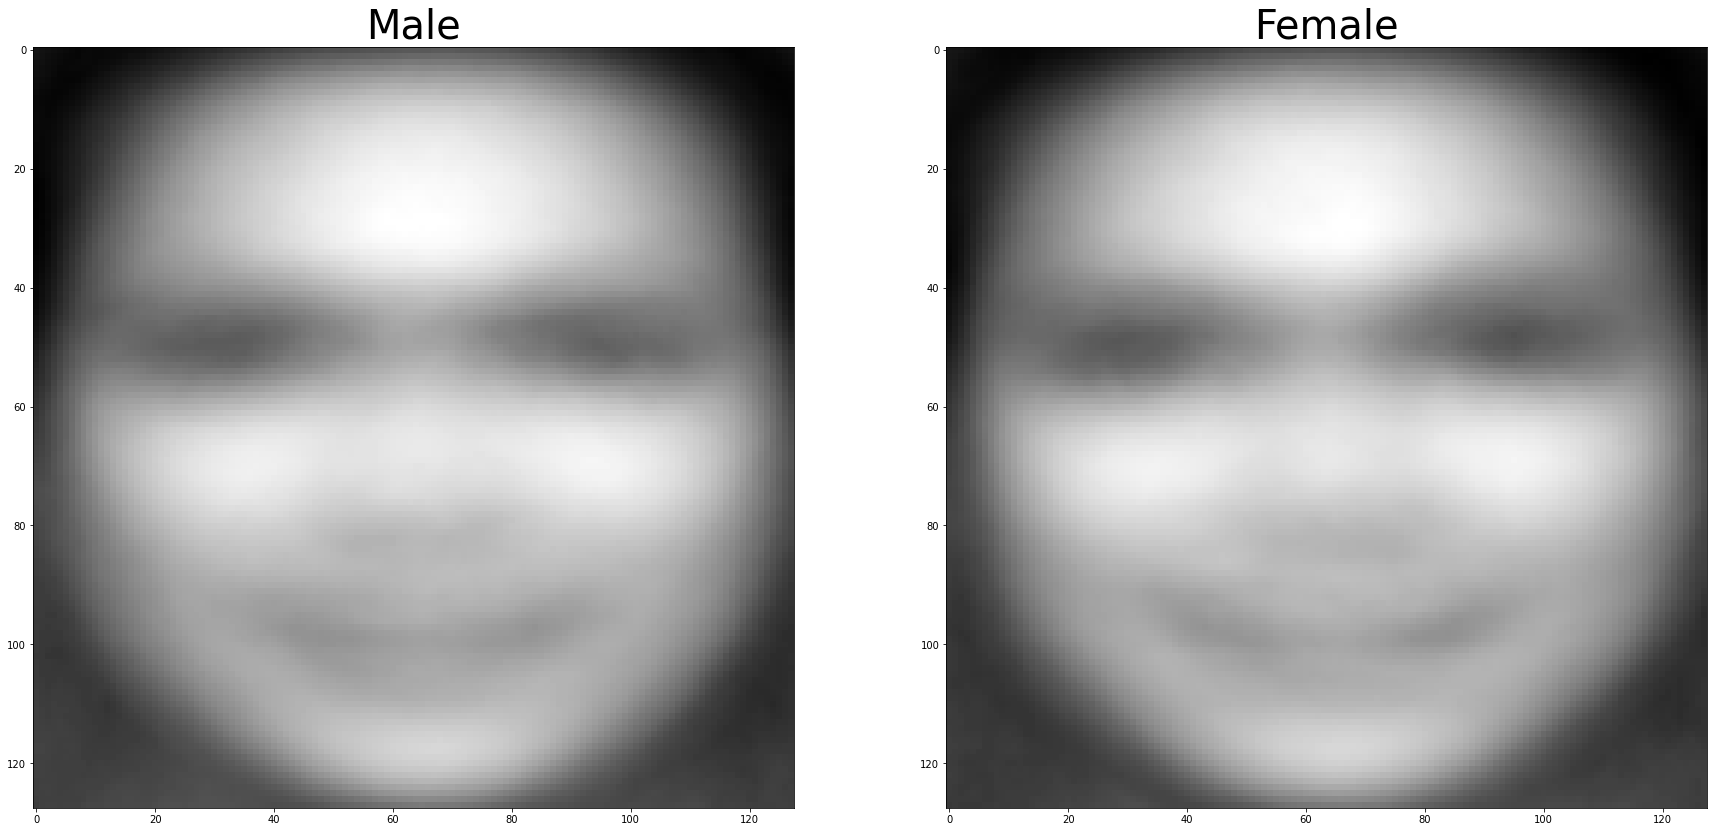

In [27]:
mimg = pca_male.mean_.reshape((128, 128))  # average male
fimg = pca_female.mean_.reshape((128, 128))  # average female

fig, axes = plt.subplots(1, 2, figsize=(30, 20))
for ax, img, gender in zip(axes, [mimg, fimg], ['Male', 'Female']):
    ax.imshow(img, cmap='gray')
    ax.set_title(gender, fontsize=40)

plt.show()

__Разница невелика. Грустно.__


__Посмотрим на опорные "лица", чтобы понимать, на что вообще обращается внимание.__

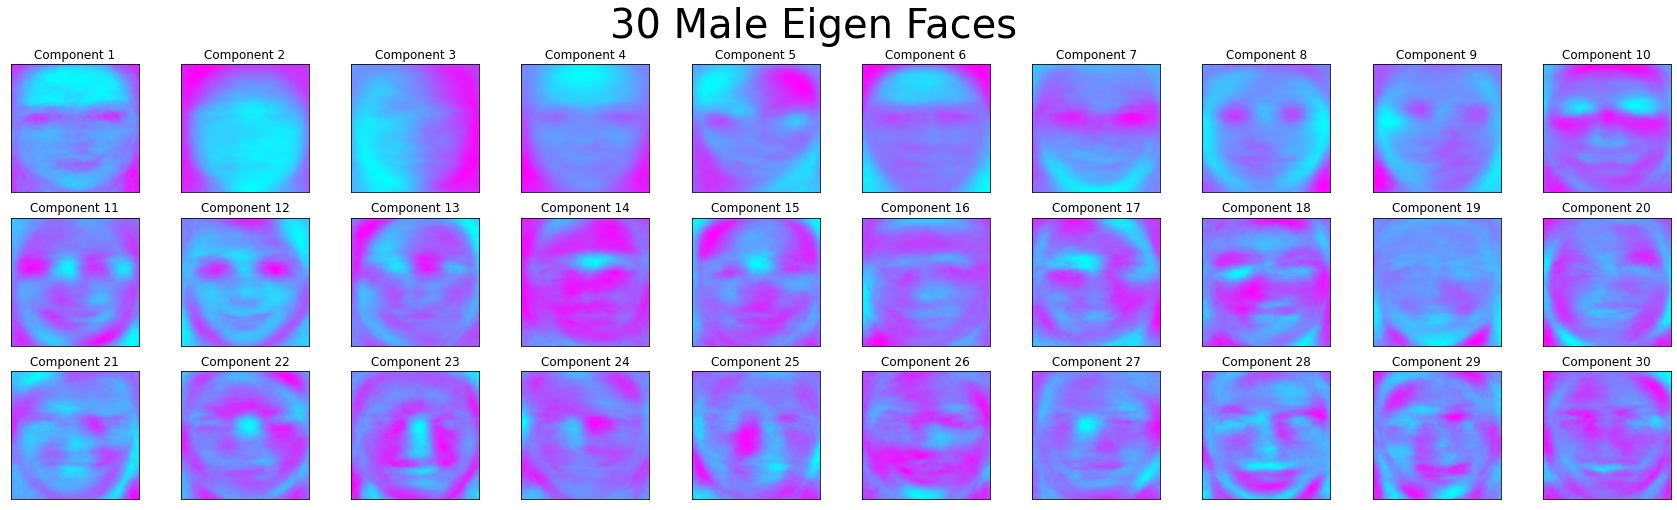

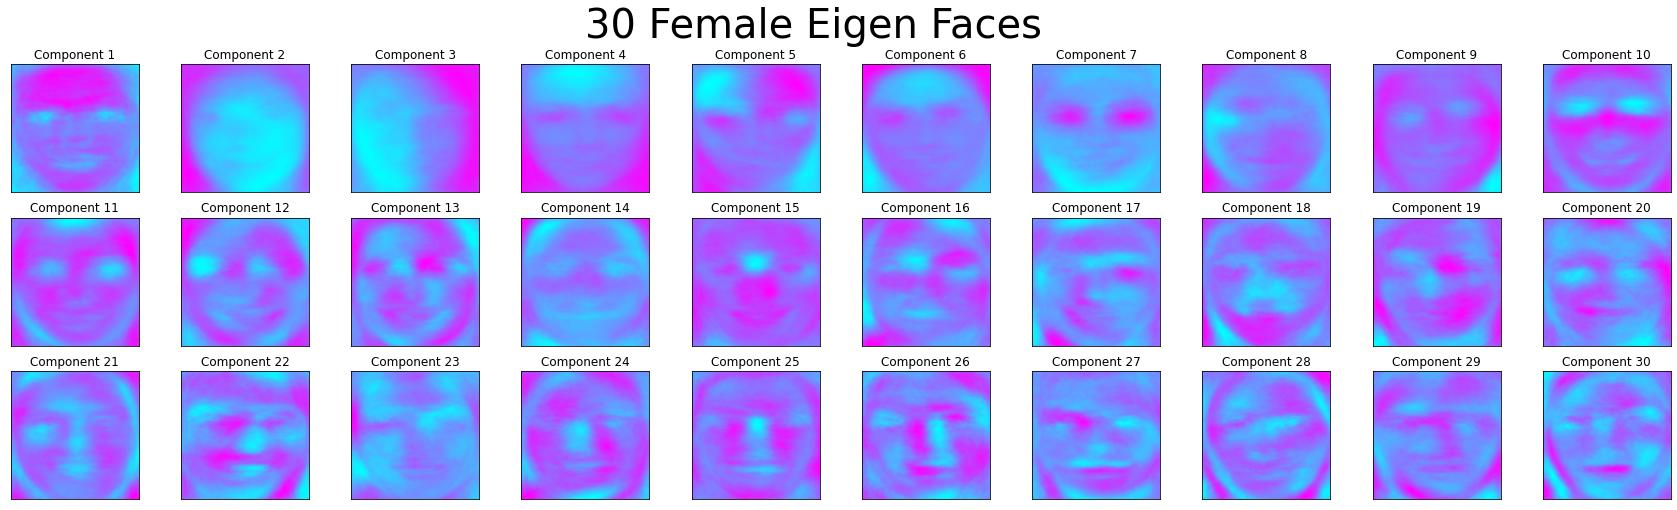

In [28]:
rendering.eigen_faces(pca_male, 'male')
rendering.eigen_faces(pca_female, 'female')

Ну на самом деле разница в форме и чертах типа бровей, носа, скул вроде бы есть, очень сложно сказать. Попробуем обучить модель.

## Классификация: State of the art models

In [29]:
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X);
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [30]:
models = dict(
Logit=LogisticRegression(C=100.),
NB=GaussianNB(),              
LDA=LinearDiscriminantAnalysis(n_components=1, solver='lsqr', tol=1e-3),
KNN=KNeighborsClassifier(n_neighbors=50, weights='distance', algorithm='kd_tree', p=3),              
SVC=SVC(kernel='rbf', degree=3, gamma='scale', probability=True),
GB=GradientBoostingClassifier(loss='exponential', learning_rate=.1, n_estimators=200, criterion='friedman_mse'),
AdaBoost=AdaBoostClassifier(n_estimators=70, learning_rate=.05),
RandomForest=RandomForestClassifier(n_estimators=80, criterion='entropy', max_features='sqrt',
                                   max_depth=20, min_samples_leaf=10, min_weight_fraction_leaf=.005)
)
    
proba_arr = clf_proba_pipeline(models, X_train_pca, X_test_pca, y_train, y_test)  # models y predicted
accuracy_arr = threshhold_clf_controller(models, proba_arr, y_test)  # each model 100 accuracies

x = np.array([np.linspace(0, 1, 100) for model in models], dtype='float32')
y = np.array([accuracy_arr.get(model) for model in models], dtype='float32')

rendering.scatter_plotly(x=x, y=y, mode='lines', name=models.keys(), fill='tozeroy',\
                         title_='Accuracy of probability threshhold', x_label='Threshhold', y_label='Accuracy score')

In [31]:
accuracy_best_ = {model: np.max(accuracy_arr.get(model)) for model in models}
best_model, best_acc = 'Logit', 0.5
for model, acc in accuracy_best_.items():
    best_model = model if acc > best_acc else best_model
    best_acc = accuracy_best_.get(best_model)
    print(f'==== Model ===== {model} =====')
    print(f'Best Accuracy is {acc :.4f}')

print('-----------------------------------------')
print(f'Best model is {best_model} with accuracy {best_acc :.4f}')

==== Model ===== Logit =====
Best Accuracy is 0.7625
==== Model ===== NB =====
Best Accuracy is 0.7400
==== Model ===== LDA =====
Best Accuracy is 0.7700
==== Model ===== KNN =====
Best Accuracy is 0.7800
==== Model ===== SVC =====
Best Accuracy is 0.8400
==== Model ===== GB =====
Best Accuracy is 0.7750
==== Model ===== AdaBoost =====
Best Accuracy is 0.6525
==== Model ===== RandomForest =====
Best Accuracy is 0.7675
-----------------------------------------
Best model is SVC with accuracy 0.8400


Неплохой бейзлайн

Лучшее качество показывает SVM, также можно попробовать настроить KNN и бустинг.


### Настройка трех лучших  моделей: Grid search 

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

selected_models = (KNeighborsClassifier(), GradientBoostingClassifier(), SVC(probability=True))

# Defining the hyperparameters to optimize
grid_parameters = [
    { # KNN
    'n_neighbors': [53, 60, 80],  # [30, 50, 60, 80, 100]
    'weights': ['distance'],  # ['uniform', 'distance']
    'p': [2, 3],  # [1, 2, 3, 5, 8]
    'leaf_size': [5, 20]  # [5, 20, 40, 70] 
    },
     { # GB
    'loss': ['exponential'],  # ['deviance', 'exponential']
    'learning_rate': [.5],  # [.1, .5, 1.]
    'n_estimators': [100, 150],  # [50, 100, 150]
    'criterion': ['friedman_mse', 'mse']  # ['friedman_mse', 'mse']
    },
     { # SVM
    'kernel': ['rbf', 'sigmoid'],  # ['poly', 'rbf', 'sigmoid']
#     'degree': [2, 3, 5, 9],  
    'gamma': ['scale', 'auto'], # ['scale', 'auto']
#     'coef0': [.0, .02, .05],  # [.0, .02, .05]
    'decision_function_shape': ['ovo', 'ovr']  # ['ovo', 'ovr']
    }]

In [33]:
%%time
models_preds_scores = []

for i, model in enumerate(selected_models):
    params = grid_parameters[i]
    
    result = GS_pipeline(X_train_pca, X_test_pca, y_train, y_test, 
                                 model, params, cv=10)
    models_preds_scores.append(result)

Current model: KNeighborsClassifier()
Current model: GradientBoostingClassifier()
Current model: SVC(probability=True)
CPU times: user 4.41 s, sys: 250 ms, total: 4.66 s
Wall time: 42.5 s


In [34]:
for result in models_preds_scores:
    print(f'==== {str(type(result[0])).split(".")[-1][:-2]} =====')    
    print(f'Accuracy score is: {result[2]}')

==== KNeighborsClassifier =====
Accuracy score is: 0.7625
==== GradientBoostingClassifier =====
Accuracy score is: 0.7375
==== SVC =====
Accuracy score is: 0.8375


According to the cross validation scores Linear Discriminant Analysis and Logistic Regression still have best performance

### GS сохранение результатов

In [35]:
knn, boosting, svm = [models_preds_scores[i][0] for i in range(3)] 

__Топ классификатор - SVM__

In [36]:
svm

SVC(decision_function_shape='ovo', gamma='auto', probability=True)

In [37]:
models = dict(KNN=knn, GB=boosting, SVC=svm) 
proba_arr = clf_proba_pipeline(models, X_train_pca, X_test_pca, y_train, y_test)  # models y predicted
accuracy_arr = threshhold_clf_controller(models, proba_arr, y_test)  # each model 100 accuracies

x = np.array([np.linspace(0, 1, 100) for model in models], dtype='float32')
y = np.array([accuracy_arr.get(model) for model in models], dtype='float32')

rendering.scatter_plotly(x=x, y=y, mode='lines', name=models.keys(), fill='tozeroy',\
                         title_='Accuracy of probability threshhold', x_label='Threshhold', y_label='Accuracy score')

In [38]:
accuracy_best_ = {model: np.max(accuracy_arr.get(model)) for model in models}
best_model, best_acc = 'Logit', 0.5
for model, acc in accuracy_best_.items():
    best_model = model if acc > best_acc else best_model
    best_acc = accuracy_best_.get(best_model)
    print(f'==== Model ===== {model} =====')
    print(f'Best Accuracy is {acc :.4f}')

print('-----------------------------------------')
print(f'Best model is {best_model} with accuracy {best_acc :.4f}')

==== Model ===== KNN =====
Best Accuracy is 0.7850
==== Model ===== GB =====
Best Accuracy is 0.7525
==== Model ===== SVC =====
Best Accuracy is 0.8375
-----------------------------------------
Best model is SVC with accuracy 0.8375


Видим, что SVC дает лучшее качество при пороге 0.4, но вот KNN сильно лучше со значением 0.5. В совместной модели лучше брать 0.5

__И другие метрики__

In [39]:
from sklearn.metrics import classification_report

threshhold = .53  # threshold from the plot
y_pred = np.where(proba_arr.get(best_model)[:, 1] > threshhold, 1, 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       205
           1       0.83      0.81      0.82       195

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



### Precision-Recall-ROC

In [41]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test,
    y_pred)
average_precision = average_precision_score(y_test, y_pred)
print(f'Average precision score: {average_precision :0.2f}')

Average precision score: 0.77


### Model stacking

Использование стэка моделей различной природы обычно позволяет улучшить качество на пару процентов. Посмотрим, что будет в этой задаче.

In [47]:
stack = StackingCVClassifier(classifiers=(knn, boosting, svm), 
                            meta_classifier=svm, cv=5,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False)

stack.fit(X_train_pca, y_train)
pred = stack.predict_proba(X_test_pca)
score = accuracy_score(y_test, pred)
print(f'Model stack score is {score}')

Model stack score is 0.84


In [56]:
proba_arr = clf_proba_pipeline(dict(stack=stack), X_train_pca, X_test_pca, y_train, y_test)  # models y predicted
accuracy_arr = threshhold_clf_controller(dict(stack=stack), proba_arr, y_test)  # each model 100 accuracies
accuracy_best_ = {model: np.max(accuracy_arr.get(model)) for model in dict(stack=stack)}

threshhold = .52  # threshold from the plot

y_pred = np.where(proba_arr.get('stack')[:, 1] > threshhold, 1, 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       205
           1       0.83      0.85      0.84       195

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



Не самый высокий прирост качества.

## Итог

Работа с подвыборкой grayscale изображений и алгоритмами классификации проведена. Результаты неплохие, но вряд ли это можно считать решением.

Следующий ноутбук описывает подход с нейросетями. В этом случае уже можно брать полную выборку.  